#  Прогнозирование заказов такси

**Описание проекта**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

**Инструкция по выполению проекта**

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.

**Описание данных**

Данные лежат в файле /datasets/taxi.csv. Скачать датасет. 

Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

In [1]:
# для решения задачи подключим необходимые библиотеки
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import time

pd.options.display.max_colwidth = 100

RANDOM_STATE = 12345

## Подготовка

In [2]:
#прочтем данные преобразуем тип данных столбца даты в формат даты/ времени и зададим индексы столбцов равным столбцу с датой
data = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime')
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
print(data.info())
print()
print(f'Количество строк {data.shape[0]}, количество столбцов {data.shape[1]}')

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None

Количество строк 26496, количество столбцов 1


In [4]:
data.isna().sum()

num_orders    0
dtype: int64

Посмотрим за какой период времени нам предоставили данные.

In [5]:
print(f'Начальная дата: {data.index.min()}, конечная дата: {data.index.max()}')

Начальная дата: 2018-03-01 00:00:00, конечная дата: 2018-08-31 23:50:00


Посмотрим в каком хронологическом порядке находяться данные.

In [6]:
print(data.index.is_monotonic)

True


Данные выставленны в хронологическом порядке.

Произведем рассемплирование данных по часам

In [7]:
data = data.resample('1H').sum()
data

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


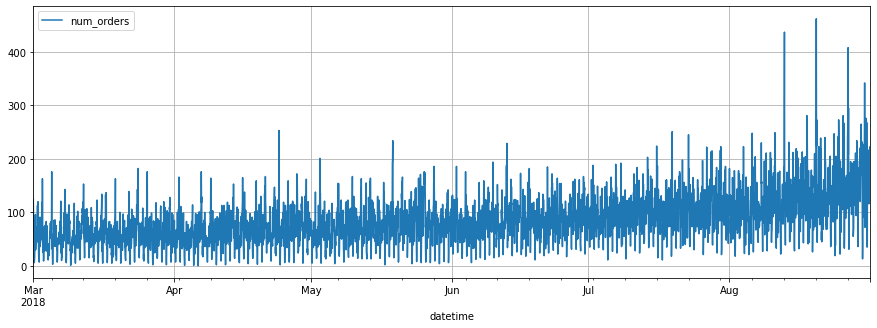

In [8]:
data.plot(figsize=(15, 5))
plt.grid(visible=True)
plt.show()

## Анализ

Добавим скользящие средние с разбивкой по дням и неделям

In [9]:
data['average_per_day'] = data['num_orders'].rolling(24).mean()
data['weekly_average'] = data['num_orders'].rolling(24*7).mean()

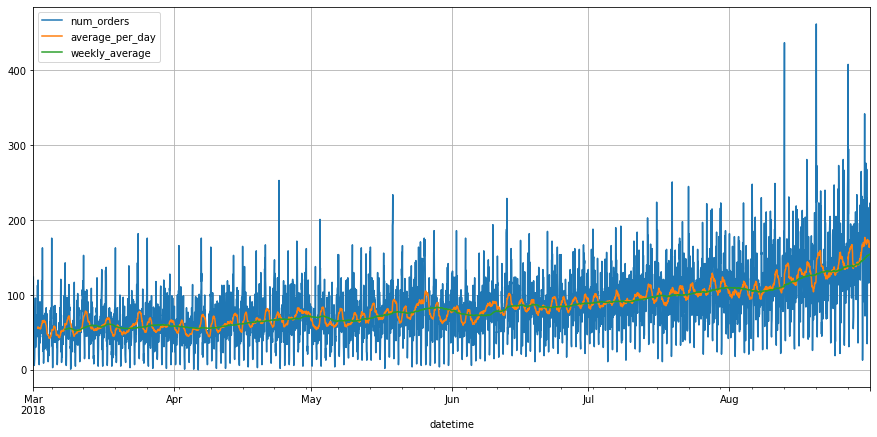

In [10]:
data.plot(figsize=(15, 7))
plt.grid(visible=True)
plt.show()

Разобъем временный ряд на тренд и сезонность

In [11]:
decomposed = seasonal_decompose(data['num_orders'])

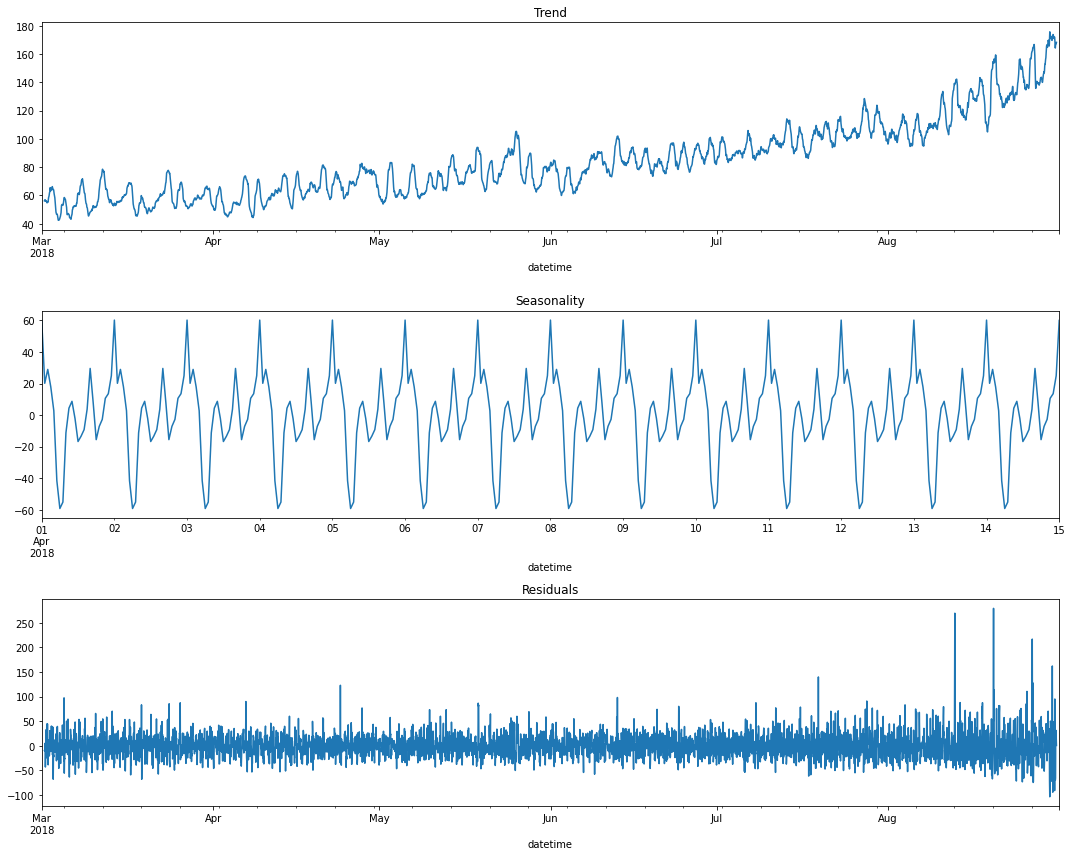

In [12]:
plt.figure(figsize=(15, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlim('2018-04', '2018-04-15')
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Для определения сезонности внутри дня следует выбрать короткий период в течении 1-2 дней.

Возьмем 2 дня за период августа месяца.

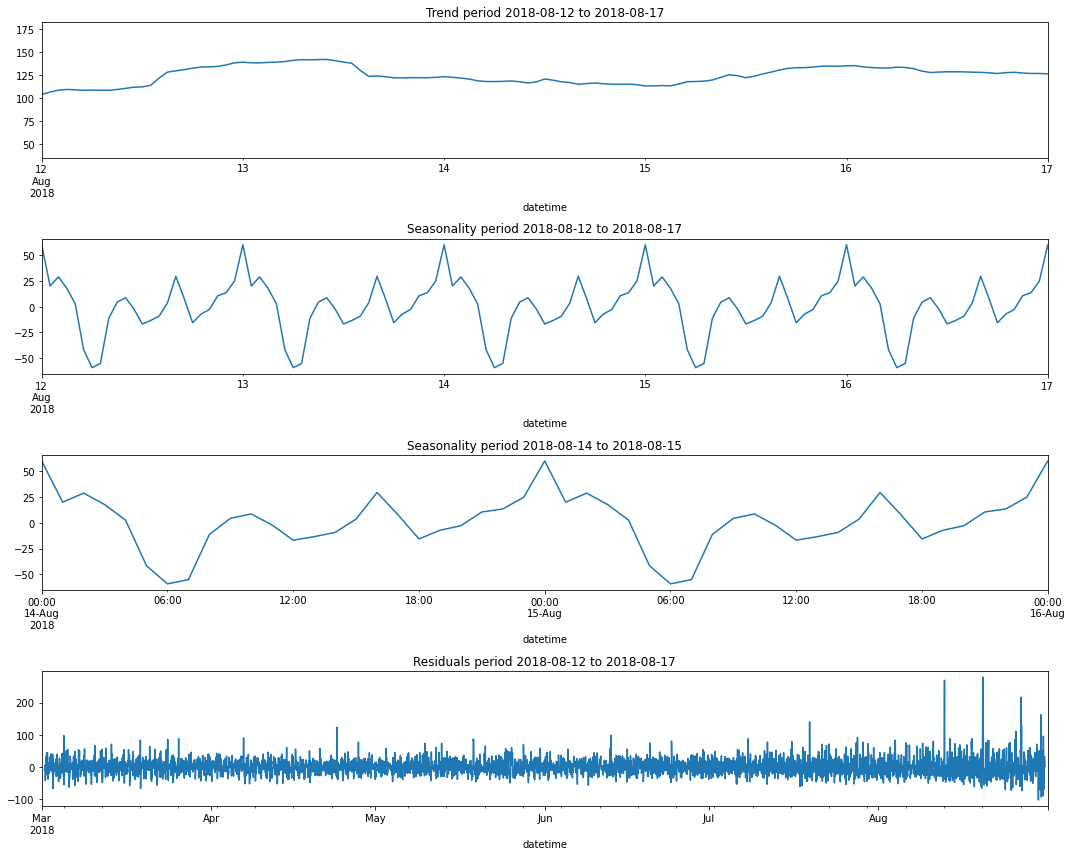

In [13]:
plt.figure(figsize=(15, 12))
plt.subplot(411)
decomposed.trend.plot(ax=plt.gca())
plt.xlim('2018-08-12', '2018-08-17')
plt.title('Trend period 2018-08-12 to 2018-08-17')
plt.subplot(412)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlim('2018-08-12', '2018-08-17')
plt.title('Seasonality period 2018-08-12 to 2018-08-17')
plt.subplot(413)
decomposed.seasonal.plot(ax=plt.gca())
plt.xlim('2018-08-14', '2018-08-16')
plt.title('Seasonality period 2018-08-14 to 2018-08-15')
plt.subplot(414)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals period 2018-08-12 to 2018-08-17')
plt.tight_layout()

В течении всего предоставленного периода количество заказов такси - увеличилось, что видно по тренду. Также по графику сезонности видно, что минимальный  спрос на такси в 6-7 часов утра и наибольший спрос в полночь (24:00).

Найдем скользящее стандартное отклонение.

In [14]:
data['mean'] = data['num_orders'].rolling(160).mean()
data['std'] = data['num_orders'].rolling(160).std()

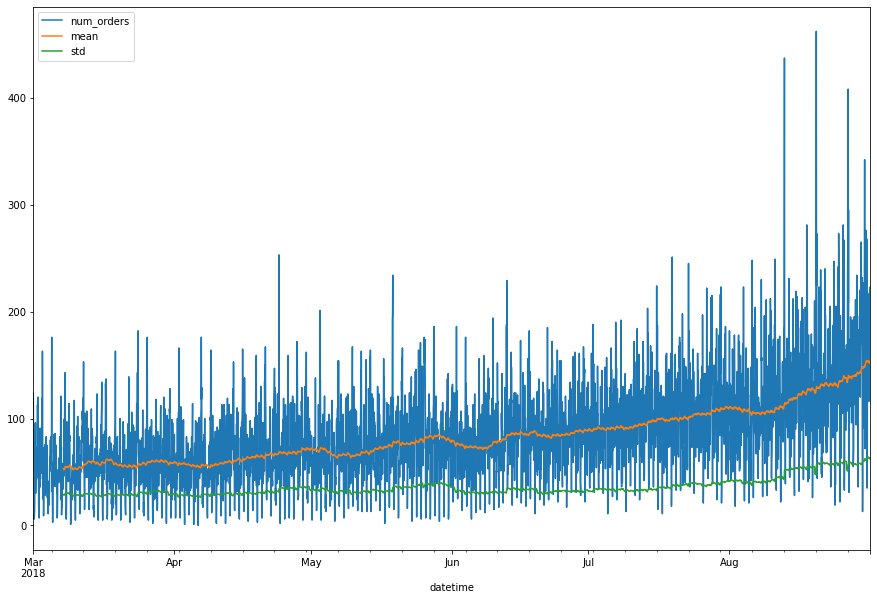

In [15]:
data[['num_orders', 'mean', 'std']].plot(figsize=(15, 10))
plt.show()

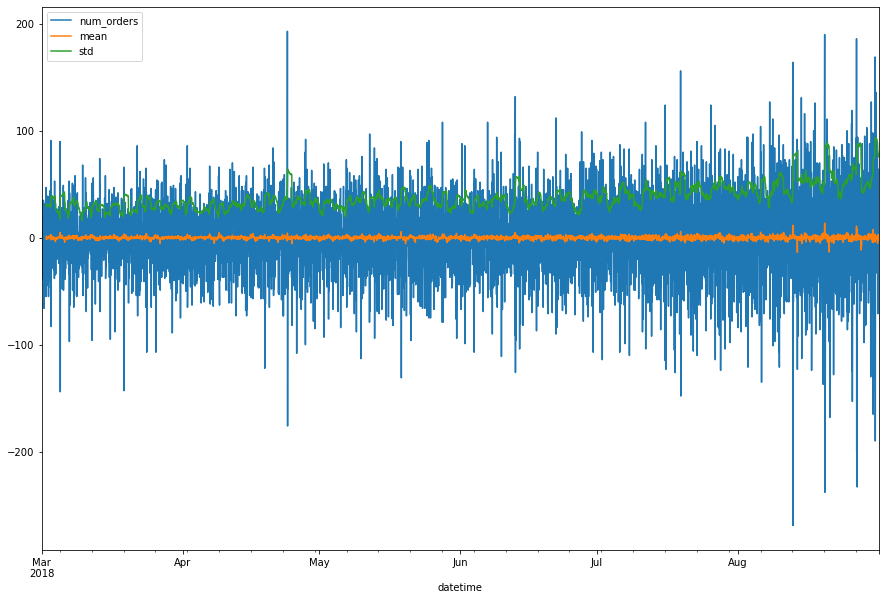

In [16]:
data_shift = data.copy()
data_shift = data_shift - data_shift.shift()
data_shift['mean'] = data_shift['num_orders'].rolling(24).mean()
data_shift['std'] = data_shift['num_orders'].rolling(24).std()
data_shift[['num_orders', 'mean', 'std']].plot(figsize=(15, 10))
plt.show()

Исходя из проведенного анализа видно, что есть сезонность в течении дня, заметна возрастающая тенденция исходя из тренда, то есть есть увеличивается количество заказов. Среднее и стандартное отклонение меняются в течении времени, то есть график не стационарный. 

## Обучение

Создадим признаки для прогнозирования

In [17]:
#напишем функцию для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [18]:
data = data.drop(columns=['average_per_day', 'weekly_average', 'mean', 'std'])
display(data)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


Определим скользящее среднее как половина дня, т.е. равным 12, а разность временного ряда примем как суточную, т.е. значение 24.

In [19]:
make_features(data, 24, 12)
data

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,133.0,...,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,72.0,163.416667
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,116.0,...,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,142.0,170.916667
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,197.0,...,78.0,268.0,99.0,230.0,194.0,276.0,246.0,158.0,198.0,168.583333


In [20]:
#разделим данные на обучающую и тестовую выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

train = train.dropna()
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3950, 29)
(442, 29)
(3950,)
(442,)


In [21]:
X_train

,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,2018,3,2,4,58.0,113.0,66.0,61.0,45.0,73.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.583333
2018-03-02 01:00:00,2018,3,2,4,90.0,58.0,113.0,66.0,61.0,45.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.583333
2018-03-02 02:00:00,2018,3,2,4,120.0,90.0,58.0,113.0,66.0,61.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,68.916667
2018-03-02 03:00:00,2018,3,2,4,75.0,120.0,90.0,58.0,113.0,66.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.166667
2018-03-02 04:00:00,2018,3,2,4,64.0,75.0,120.0,90.0,58.0,113.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,71.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,2018,8,13,0,91.0,39.0,66.0,83.0,143.0,168.0,...,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,108.0,158.166667
2018-08-13 10:00:00,2018,8,13,0,137.0,91.0,39.0,66.0,83.0,143.0,...,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,108.0,158.333333
2018-08-13 11:00:00,2018,8,13,0,156.0,137.0,91.0,39.0,66.0,83.0,...,82.0,78.0,115.0,153.0,149.0,104.0,120.0,123.0,81.0,161.500000


In [22]:
def cv_model(model, params, X, y):
    time_cv = TimeSeriesSplit(n_splits=5)
    best_model = GridSearchCV(model
                              , param_grid = params
                              , scoring = 'neg_root_mean_squared_error'
                              , cv = time_cv
                              , verbose = 5)
    return best_model.fit(X, y)

### Рассмотрим модель линейной регрессии

In [27]:
%%time

time_cv = TimeSeriesSplit(n_splits=5)
model_lr = cross_val_score(LinearRegression()
                           , X_train
                           , y_train
                           , scoring='neg_root_mean_squared_error'
                           , cv=time_cv
                           , verbose = 5)
print(f'Показатель RMSE для модели линейной регрессии: {model_lr.mean()}')

[CV] END .............................. score: (test=-24.728) total time=   0.0s
[CV] END .............................. score: (test=-24.380) total time=   0.0s
[CV] END .............................. score: (test=-25.404) total time=   0.0s
[CV] END .............................. score: (test=-27.242) total time=   0.0s
[CV] END .............................. score: (test=-33.348) total time=   0.0s
Показатель RMSE для модели линейной регрессии: -27.020277978821532
CPU times: total: 78.1 ms
Wall time: 45 ms


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


### Рассмотрим модель дерево решений

In [28]:
%%time

parametrs_dtr = {'random_state': [RANDOM_STATE]
                 , 'max_depth': range (2, 15)
                 , 'min_samples_leaf': range(20, 31)}

best_model_dtr = cv_model(DecisionTreeRegressor()
                          , parametrs_dtr
                          , X_train
                          , y_train)

print(f'Лучшие параметры модели дерева решений: {best_model_dtr.best_params_}')
print(f'Лучший показатель RMSE для дерева решений: {best_model_dtr.best_score_}')

Fitting 5 folds for each of 143 candidates, totalling 715 fits
[CV 1/5] END max_depth=2, min_samples_leaf=20, random_state=12345;, score=-25.672 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=20, random_state=12345;, score=-30.093 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=20, random_state=12345;, score=-28.981 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=20, random_state=12345;, score=-32.051 total time=   0.0s
[CV 5/5] END max_depth=2, min_samples_leaf=20, random_state=12345;, score=-44.150 total time=   0.0s
[CV 1/5] END max_depth=2, min_samples_leaf=21, random_state=12345;, score=-25.663 total time=   0.0s
[CV 2/5] END max_depth=2, min_samples_leaf=21, random_state=12345;, score=-30.093 total time=   0.0s
[CV 3/5] END max_depth=2, min_samples_leaf=21, random_state=12345;, score=-28.981 total time=   0.0s
[CV 4/5] END max_depth=2, min_samples_leaf=21, random_state=12345;, score=-32.051 total time=   0.0s
[CV 5/5] END max_depth=2, mi

### Рассмотрим модель случайного леса

In [29]:
%%time

parametrs_rfr = {'random_state': [RANDOM_STATE]
                 , 'n_estimators': range(100, 501, 100)
                 , 'max_depth': range(5, 10)
                 , 'min_samples_leaf': range(20, 26)}

best_model_rfr = cv_model(RandomForestRegressor()
                          , parametrs_rfr
                          , X_train
                          , y_train)

print(f'Лучшие параметры модели случайного леса: {best_model_rfr.best_params_}')
print(f'Лучший показатель RMSE для случайного леса: {best_model_rfr.best_score_}')

Fitting 5 folds for each of 150 candidates, totalling 750 fits
[CV 1/5] END max_depth=5, min_samples_leaf=20, n_estimators=100, random_state=12345;, score=-23.419 total time=   0.2s
[CV 2/5] END max_depth=5, min_samples_leaf=20, n_estimators=100, random_state=12345;, score=-24.637 total time=   0.5s
[CV 3/5] END max_depth=5, min_samples_leaf=20, n_estimators=100, random_state=12345;, score=-25.679 total time=   0.8s
[CV 4/5] END max_depth=5, min_samples_leaf=20, n_estimators=100, random_state=12345;, score=-27.786 total time=   0.9s
[CV 5/5] END max_depth=5, min_samples_leaf=20, n_estimators=100, random_state=12345;, score=-37.694 total time=   1.1s
[CV 1/5] END max_depth=5, min_samples_leaf=20, n_estimators=200, random_state=12345;, score=-23.488 total time=   0.5s
[CV 2/5] END max_depth=5, min_samples_leaf=20, n_estimators=200, random_state=12345;, score=-24.545 total time=   1.1s
[CV 3/5] END max_depth=5, min_samples_leaf=20, n_estimators=200, random_state=12345;, score=-25.657 tota

### Рассмотрим модель LightGBMRegressor

In [30]:
%%time

parametrs_lgbmr = {'random_state': [RANDOM_STATE]
                   , 'n_estimators': range(100, 501, 100)
                   , 'max_depth': range(5, 10)
                   , 'num_leaves': range(20, 26)
                   , 'learning_rate': [0.3, 0.4, 0.5]}

best_model_lgbmr = cv_model(LGBMRegressor()
                            , parametrs_lgbmr
                            , X_train
                            , y_train)

print(f'Лучшие параметры модели LightGBMRegressor: {best_model_lgbmr.best_params_}')
print(f'Лучший показатель RMSE для LightGBMRegressor: {best_model_lgbmr.best_score_}')

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=100, num_leaves=20, random_state=12345;, score=-23.910 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=100, num_leaves=20, random_state=12345;, score=-23.316 total time=   0.0s
[CV 3/5] END learning_rate=0.3, max_depth=5, n_estimators=100, num_leaves=20, random_state=12345;, score=-25.530 total time=   0.0s
[CV 4/5] END learning_rate=0.3, max_depth=5, n_estimators=100, num_leaves=20, random_state=12345;, score=-27.858 total time=   0.0s
[CV 5/5] END learning_rate=0.3, max_depth=5, n_estimators=100, num_leaves=20, random_state=12345;, score=-34.013 total time=   0.0s
[CV 1/5] END learning_rate=0.3, max_depth=5, n_estimators=100, num_leaves=21, random_state=12345;, score=-23.932 total time=   0.0s
[CV 2/5] END learning_rate=0.3, max_depth=5, n_estimators=100, num_leaves=21, random_state=12345;, score=-23.231 total time=   0.0s
[CV 3/5] END

### Рассмотрим модель CatBoostRegressor

In [31]:
%%time

parametrs_cbr = {'random_state': [RANDOM_STATE]
                 , 'depth': range(3, 10)
                 , 'learning_rate': [0.3, 0.4, 0.5]
                 , 'iterations': range(10, 21)}

best_model_cbr = cv_model(CatBoostRegressor()
                            , parametrs_cbr
                            , X_train
                            , y_train)

print(f'Лучшие параметры модели CatBoostRegressor: {best_model_cbr.best_params_}')
print(f'Лучший показатель RMSE для CatBoostRegressor: {best_model_cbr.best_score_}')

Fitting 5 folds for each of 231 candidates, totalling 1155 fits
0:	learn: 26.1308265	total: 144ms	remaining: 1.3s
1:	learn: 23.8666541	total: 145ms	remaining: 581ms
2:	learn: 22.4810452	total: 146ms	remaining: 341ms
3:	learn: 21.5428925	total: 147ms	remaining: 221ms
4:	learn: 20.6967766	total: 148ms	remaining: 148ms
5:	learn: 20.1453490	total: 149ms	remaining: 99.4ms
6:	learn: 19.5892095	total: 150ms	remaining: 64.3ms
7:	learn: 19.1624320	total: 151ms	remaining: 37.7ms
8:	learn: 18.8234069	total: 152ms	remaining: 16.9ms
9:	learn: 18.6207086	total: 153ms	remaining: 0us
[CV 1/5] END depth=3, iterations=10, learning_rate=0.3, random_state=12345;, score=-23.061 total time=   0.1s
0:	learn: 27.1440262	total: 1.31ms	remaining: 11.8ms
1:	learn: 25.1914770	total: 2.7ms	remaining: 10.8ms
2:	learn: 23.6234662	total: 4.04ms	remaining: 9.42ms
3:	learn: 22.6381749	total: 5.23ms	remaining: 7.84ms
4:	learn: 22.0822537	total: 6.9ms	remaining: 6.9ms
5:	learn: 21.4715323	total: 7.87ms	remaining: 5.25ms


Сведем результаты в общую таблицу

In [32]:
model = ['LinearRegression', 'DecisionTreeRegressor', 'RandomForestRegressor', 'LightGBMRegressor', 'CatBoostRegressor']

params = ['-', best_model_dtr.best_params_, best_model_rfr.best_params_
          , best_model_lgbmr.best_params_, best_model_cbr.best_params_]

rmse_train = [model_lr.mean(), best_model_dtr.best_score_, best_model_rfr.best_score_
              , best_model_lgbmr.best_score_, best_model_cbr.best_score_]

#rmse_test = [mean_squared_error(y_test, model_lr.predict(X_test)) ** 0.5
#             , mean_squared_error(y_test, best_model_dtr.best_estimator_.predict(X_test)) ** 0.5
#             , mean_squared_error(y_test, best_model_rfr.best_estimator_.predict(X_test)) ** 0.5
#             , mean_squared_error(y_test, best_model_lgbmr.best_estimator_.predict(X_test)) ** 0.5
#             , mean_squared_error(y_test, best_model_cbr.best_estimator_.predict(X_test)) ** 0.5]

result = {'Model': model, 'Hyperparameters': params, 'RMSE in training': rmse_train}

display(pd.DataFrame(result))

,Model,Hyperparameters,RMSE in training
0,LinearRegression,-,-27.020278
1,DecisionTreeRegressor,"{'max_depth': 7, 'min_samples_leaf': 23, 'random_state': 12345}",-28.955052
2,RandomForestRegressor,"{'max_depth': 9, 'min_samples_leaf': 20, 'n_estimators': 200, 'random_state': 12345}",-26.854223
3,LightGBMRegressor,"{'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 20, 'random_state': 12...",-26.236746
4,CatBoostRegressor,"{'depth': 8, 'iterations': 20, 'learning_rate': 0.4, 'random_state': 12345}",-25.930169


По полученным данным видно, что самой лучшей моделью оказалась модель CatBoostRegressor c параметрами {'depth': 8, 'iterations': 20, 'learning_rate': 0.4, 'random_state': 12345} и показателем RMSE равным 25.93. Чуть хуже себя показала модель LightGBMRegressor c параметрами {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 20, 'random_state': 12345} и показателем RMSE равным 26.23. 

Проведем тестирование лучшей модели CatBoostRegressor на тестовой выборке.

## Тестирование

In [33]:
def plot_predictions(model, y, predictions):
    plt.figure(figsize=(20, 5))
    plt.plot(y.index, y_test, label='Реальные данные')
    plt.plot(y.index, predictions, label='Предсказанные данные')
    plt.title(f'Показатели по данным и предсказанные показатели для модели {model}')
    plt.legend(loc='upper right')
    plt.show()

### Проверим модель CatBoostRegressor на тестовой выборке

In [34]:
%%time

predictions_cbr_test = best_model_cbr.best_estimator_.predict(X_test)
print(f'RMSE модели дерева решений: {mean_squared_error(y_test, predictions_cbr_test) ** 0.5}')

RMSE модели дерева решений: 46.4130421116552
CPU times: total: 0 ns
Wall time: 4 ms


Визуализируем реальные данные и предсказанные

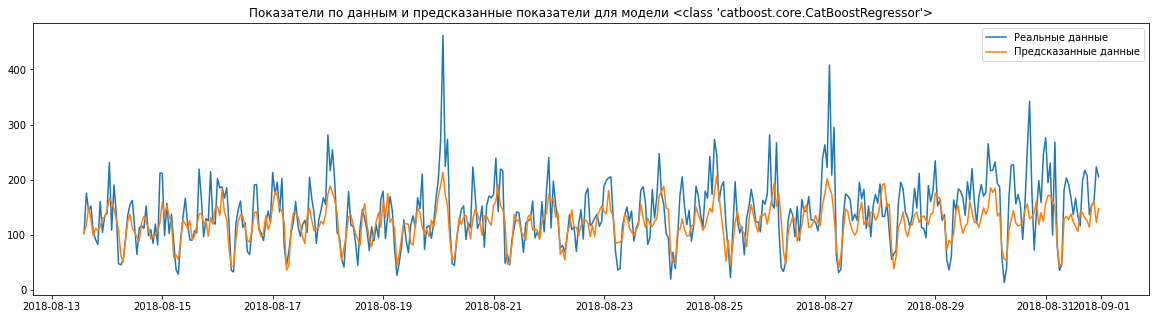

In [35]:
plot_predictions(CatBoostRegressor, y_test, predictions_cbr_test)

## Общий вывод

Открыли файл и задали индекс по столбцу с датой. 

Ознакомились с данными, данные выставлены в хронологическом порядке. 

Провели рассемплирование данных, взяли период в 1 час. 

Провели анализ данных, временных рядов: произвели декомпозицию данных, построили графики тренда и сезонности. 

Обучили разные модели и подобрали оптимальны параметры модели. 

Произвели предсказание на тестовой выборке. 

Самой лучшей моделью оказалась модель CatBoostRegressor c параметрами {'depth': 8, 'iterations': 20, 'learning_rate': 0.4, 'random_state': 12345} и показателем RMSE равным 25.93. Чуть хуже себя показала модель LightGBMRegressor c параметрами {'learning_rate': 0.3, 'max_depth': 6, 'n_estimators': 100, 'num_leaves': 20, 'random_state': 12345} и показателем RMSE равным 26.23. 

Из всех рассмотренных моделей была выбрана модель CatBoostRegressor и на тестовой выборке показатель RMSE составляет 46.41.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48